In [4]:
import os
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'
import logging
logger = logging.getLogger()
logger.setLevel(logging.WARNING)
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import multiprocessing
import itertools as it
from scipy.special import expit
import pymc3 as pm
import arviz as az
import theano.tensor as tt

In [5]:
import warnings
warnings.simplefilter('ignore')

In [6]:
# multiprocessing.set_start_method("fork")
sns.set()  # Nice plot aesthetic

In [7]:
bkp_folder = 'bkp'
os.makedirs(bkp_folder, exist_ok=True)

# Toy example: x -> f(x)

In [17]:
def true_f(x):
    return x**0.7

x = np.random.random(size=10)
y = true_f(x)

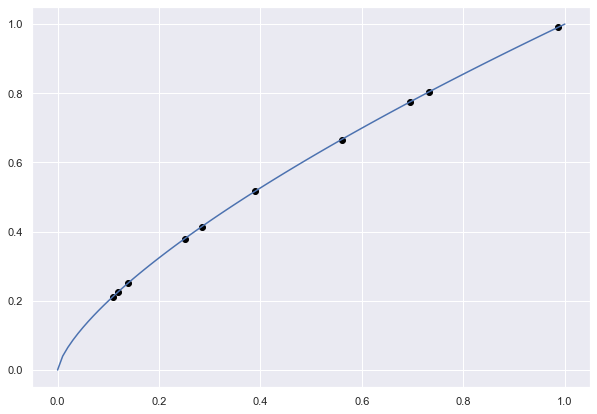

In [18]:
fig, ax = plt.subplots(figsize=(10, 7))
ax.scatter(x, y, c="black")

x_plot = np.linspace(0, 1, 100)
ax.plot(x_plot, true_f(x_plot))

In [19]:
with pm.Model() as toy_model:

    # Lengthscale
    ρ = pm.HalfCauchy('ρ', 5)
    η = pm.HalfCauchy('η', 5)
    
    M = pm.gp.mean.Linear(coeffs=0)
    K = (η**2) * pm.gp.cov.ExpQuad(1, ρ) 
    
    σ = pm.HalfNormal('σ', 1)
    
    gp = pm.gp.Marginal(mean_func=M, cov_func=K)
    gp.marginal_likelihood('y', X=x.reshape(-1, 1), y=y, noise=σ)
    

In [11]:
with toy_model:
    gp_trace = pm.sample(1000, tune=2000, cores=2, random_seed=42)

ERROR:pymc3:There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


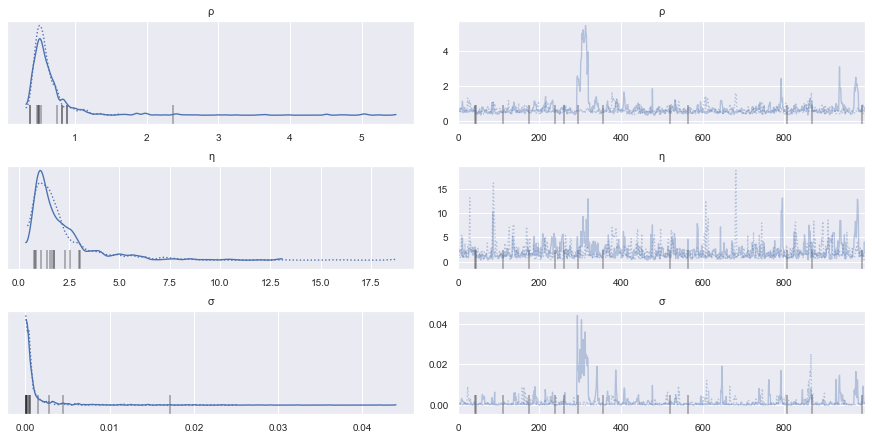

In [12]:
az.plot_trace(gp_trace, var_names=['ρ', 'η', 'σ']);

In [13]:
x_pred = np.linspace(0, 1, 100)
with toy_model:
    y_pred = gp.conditional("y_pred", x_pred.reshape(-1, 1))

In [14]:
with toy_model:
    samples = pm.sample_posterior_predictive(gp_trace, var_names=["y_pred"], samples=100, random_seed=42)

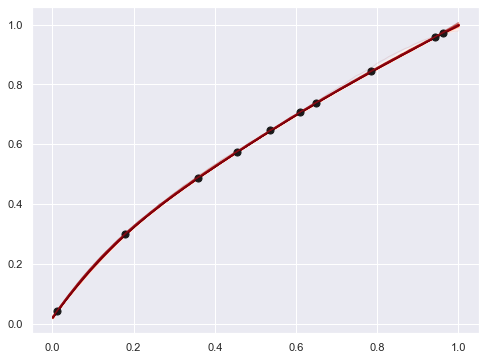

In [16]:
fig, ax = plt.subplots(figsize=(8,6))
pm.gp.util.plot_gp_dist(ax, samples['y_pred'], x_pred)
ax.scatter(x=x, y=y, c='k', s=50)

# Toy model 2: x => f(x) => choice

In [20]:
def true_f(x):
    return np.sign(x)*np.abs(x)**0.7

x = np.random.uniform(-2, 2, size=100)
x.sort()
u = true_f(x)
p_logit = 1/(1+np.exp(-3.33*u))
y = p_logit > np.random.random(len(x))

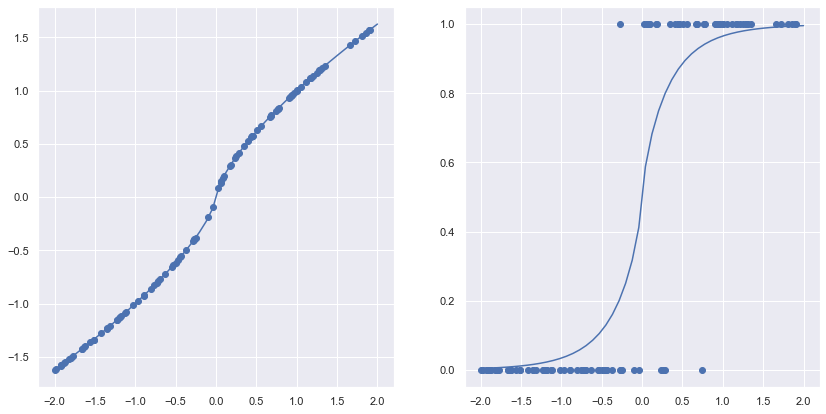

In [23]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 7))
ax = axes[0]
ax.scatter(x, u)
ax.plot(x_plot, true_f(x_plot))

ax = axes[1]
ax.scatter(x, y)
x_plot = np.linspace(-2, 2, )
ax.plot(x_plot, expit(3.33*true_f(x_plot)))

In [24]:
with pm.Model() as toy_model:
    
    ρ = pm.Normal('ρ', 1)
    η = pm.Normal('η', 1)
    
    K = η**2 * pm.gp.cov.ExpQuad(1, ρ)
    gp = pm.gp.Latent(cov_func=K)
    
    f = gp.prior('f', X=x.reshape(-1, 1))
    p = pm.Deterministic('p', pm.math.invlogit(3.33*f))
    y_ = pm.Bernoulli('y', p=p, observed=y)

In [25]:
with toy_model:
    trace = pm.sample(1000, tune=1000, chains=2)

ERROR:pymc3:There were 140 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 70 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


array([<AxesSubplot:title={'center':'ρ'}>,
       <AxesSubplot:title={'center':'η'}>], dtype=object)

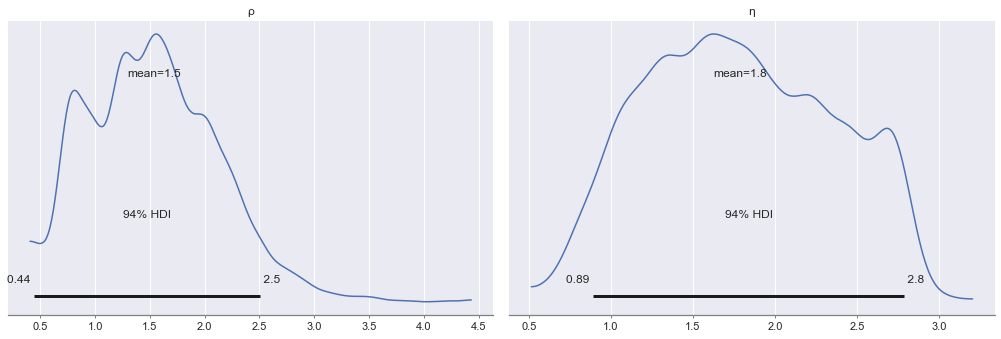

In [27]:
az.plot_posterior(trace, var_names=['ρ', 'η'])

In [32]:
with toy_model:
    y_pred = pm.sample_posterior_predictive(trace, var_names=["f", "p"], samples=1000)

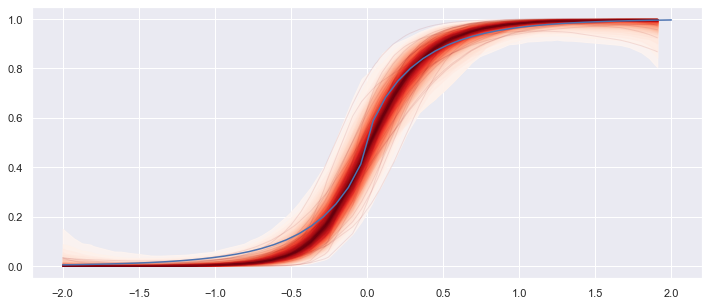

In [34]:
fig, ax = plt.subplots(figsize=(12,5))

pm.gp.util.plot_gp_dist(ax, expit(3.33*y_pred["f"]), x)
ax.plot(x_plot, expit(3.33*true_f(x_plot)))

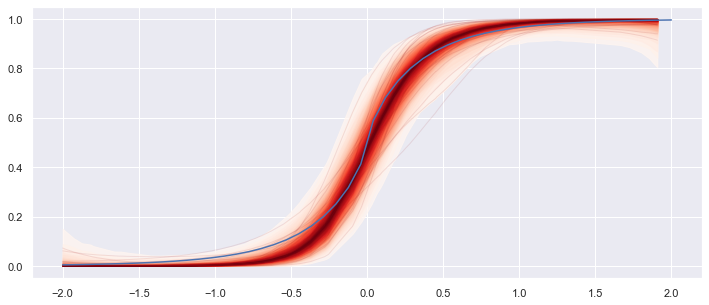

In [36]:
fig, ax = plt.subplots(figsize=(12,5))

pm.gp.util.plot_gp_dist(ax, y_pred["p"], x)
ax.plot(x_plot, expit(3.33*true_f(x_plot)))

(-2.0, 2.0)

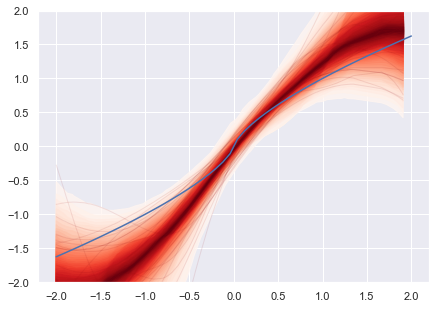

In [38]:
fig, ax = plt.subplots(figsize=(7,5))

pm.gp.util.plot_gp_dist(ax, y_pred["f"], x)
ax.plot(x_plot, true_f(x_plot))

ax.set_ylim(-2, 2)

# Lottery data

In [39]:
np.random.seed(123)

In [40]:
def u(x, alpha):
    return x**(1 - alpha)

def f_choice(x, tau):
    return expit(x*(1/tau))

In [41]:
# steps = np.linspace(0.01,0.99, 10)
# task = pd.DataFrame(np.array(list(it.product(steps, repeat=4))), columns=["p0", "x0", "p1", "x1"])
task = pd.DataFrame(np.random.random(size=(1000, 4)), columns=["p0", "x0", "p1", "x1"])
task = task[~((task.p0 >= task.p1) & (task.x0 >= task.x1))]
task = task[~((task.p1 >= task.p0) & (task.x1 >= task.x0))]

In [45]:
n_trial = len(task)

true_tau = 0.3 # 3.33 # 0.1
true_alpha = 0.4

seu0 = task.p0 * u(task.x0, true_alpha)
seu1 = task.p1 * u(task.x1, true_alpha)

diff_eu = seu1 - seu0
task['diff_eu'] = diff_eu

p_choice_1 = f_choice(diff_eu, true_tau)

choice = np.zeros(n_trial, dtype=int)
choice[:] = p_choice_1 > np.random.random(size=n_trial)
task["choice"] = choice

n = 100
task = task.sample(n=n, replace=False)
task = task.sort_values(by="diff_eu")
task.reset_index(inplace=True, drop=True)
task

,p0,x0,p1,x1,diff_eu,choice
0,0.610272,0.911365,0.060995,0.991708,-0.516526,0
1,0.931932,0.582175,0.206096,0.717758,-0.504712,0
2,0.769397,0.573774,0.102635,0.699834,-0.468459,0
3,0.782821,0.558396,0.133484,0.829552,-0.432533,0
4,0.654901,0.596849,0.072152,0.632890,-0.425668,0
...,...,...,...,...,...,...
95,0.729661,0.157371,0.692422,0.730335,0.332846,1
96,0.166744,0.828984,0.912390,0.391699,0.370941,0
97,0.020576,0.918097,0.864480,0.276902,0.380536,0
98,0.129865,0.859377,0.571432,0.836710,0.394886,1


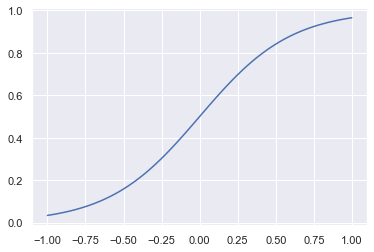

In [46]:
x_plot = np.linspace(-1, 1, 100)
plt.plot(x_plot, f_choice(x_plot, true_tau))

In [47]:
p0 = task.p0.values
p1 = task.p1.values
x0 = task.x0.values
x1 = task.x1.values
y = task.choice.values
diff_eu = task.diff_eu.values

x = np.hstack((x0, x1))
p = np.hstack((p0, p1))
x_order = np.argsort(x)
x_sorted = x[x_order]
undo_sorted = np.argsort(x_order)

u_sorted = u(x_sorted, true_alpha)
p_sorted = p[x_order]
eu_sorted = p_sorted*u_sorted
p_choice1 = f_choice(diff_eu, true_tau)

# diff_eu_sorted = eu_sorted[n:] - eu_sorted[:n]

# Re-simple x => u

In [ ]:
with pm.Model() as toy_model:

    # Lengthscale
    ρ = pm.HalfCauchy('ρ', 5)
    η = pm.HalfCauchy('η', 5)
    
    M = pm.gp.mean.Linear(coeffs=0)
    K = η**2 * pm.gp.cov.ExpQuad(1, ρ) 
    
    σ = pm.HalfNormal('σ', 50)
    
    gp = pm.gp.Marginal(mean_func=M, cov_func=K)
    gp.marginal_likelihood('y', X=x_sorted.reshape(-1, 1), y=u_sorted, noise=σ)

In [51]:
with toy_model:
    trace = pm.sample(1000, tune=1000, chains=2, return_inferencedata=True)

In [52]:
x_pred = np.linspace(0, 1, 100)
with toy_model:
    y_pred = gp.conditional("y_pred", x_pred.reshape(-1, 1))
    samples = pm.sample_posterior_predictive(gp_trace, var_names=["y_pred"], samples=10, random_seed=42)

<AxesSubplot:>

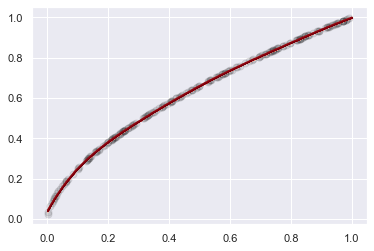

In [54]:
fig, ax = plt.subplots()
ax.scatter(x=x_sorted, y=u_sorted, c='k', s=50, alpha=0.1)
pm.gp.util.plot_gp_dist(ax, samples["y_pred"], x_pred)

# Full model

In [87]:
with pm.Model() as toy_model:

    # Lengthscale
    ρ = pm.HalfCauchy('ρ', 1)
    η = pm.HalfCauchy('η', 1)
    # ρ = pm.Normal('ρ', 1)
    # η = pm.Normal('η', 1)
    
    M = pm.gp.mean.Linear(coeffs=0)
    K = (η**2) * pm.gp.cov.ExpQuad(1, ρ) 

    gp = pm.gp.Latent(mean_func=M, cov_func=K)
    
    # Place a GP prior over the function f.
    f = gp.prior("f", X=x_sorted.reshape(-1, 1))

    est_eu =  p_sorted * f    
    est_eu_unsorted = est_eu[undo_sorted]
    
    diff_eu_hat = pm.Deterministic("diff_eu_hat", est_eu_unsorted[n:] - est_eu_unsorted[:n])
    
    tau_hat = true_tau
    est_p_choice1 = pm.Deterministic('est_p_choice1', pm.math.invlogit((1/tau_hat)*diff_eu_hat))
    choose_1 = pm.Bernoulli('choose_1', p=est_p_choice1, observed=y)

In [88]:
with toy_model:
    # trace = pm.find_MAP()
    trace = pm.sample(1000, tune=1000, chains=2, return_inferencedata=True, 
                      target_accept=0.95)

<AxesSubplot:>

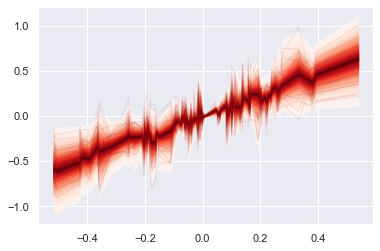

In [72]:
fig, ax = plt.subplots()
# ax.plot(trace['diff_eu_hat', 0, 0].T, 'r', alpha=.03)
pm.gp.util.plot_gp_dist(ax, trace.posterior["diff_eu_hat"][0, :, :], diff_eu)

<AxesSubplot:>

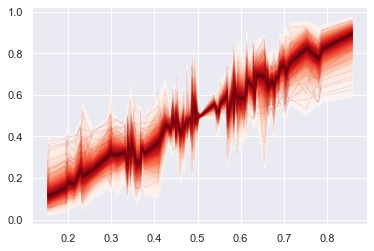

In [73]:
fig, ax = plt.subplots()
pm.gp.util.plot_gp_dist(ax, trace.posterior["est_p_choice1"][0, :, :], p_choice1)

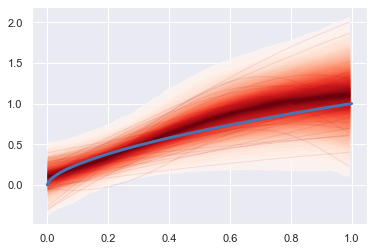

In [79]:
fig, ax = plt.subplots()
pm.gp.util.plot_gp_dist(ax, trace.posterior["f"][0, :, :], x_sorted)

x_plot = np.linspace(0, 1, 100)
# ax.scatter(x_sorted, u(x_sorted, alpha=true_alpha), color='b', alpha=0.2)
ax.plot(x_plot, u(x_plot, alpha=true_alpha), lw=3)

array([<AxesSubplot:title={'center':'ρ'}>,
       <AxesSubplot:title={'center':'η'}>], dtype=object)

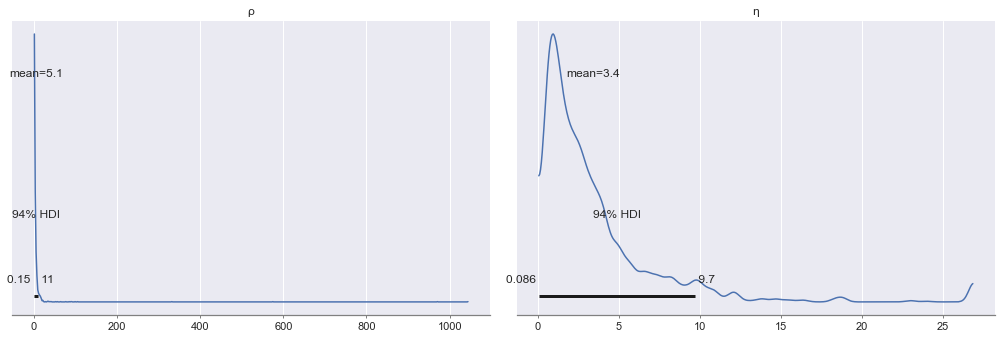

In [77]:
az.plot_posterior(trace, var_names=['ρ', 'η'])

In [ ]:
# x_plot = np.linspace(0, 1, 100)

# fig, axes = plt.subplots(ncols=2, figsize=(14, 7))
# ax = axes[0]
# ax.scatter(x, u)
# ax.plot(x_plot, true_f(x_plot))

In [ ]:
# df = az.summary(trace, round_to=2)
# with toy_model:
#     display(df)

# for i in df.index:
#     print(i)

In [ ]:
# trace

In [ ]:
#pm.gp.util.plot_gp_dist(ax, trace.posterior["f"][0, :, :], x_sorted)
#plt.show()

In [ ]:
# n_new = 100
# X_new = np.linspace(0, 1, n_new)[:, None]

# # add the GP conditional to the model, given the new X values
# with toy_model:
#     f_pred = gp.conditional("f_pred", X_new)

# # Sample from the GP conditional distribution
# with toy_model:
#     pred_samples = pm.sample_posterior_predictive(trace.posterior, var_names=["f_pred"])

In [ ]:
# lin_func = pm.gp.mean.Linear(coeffs=(1,), intercept=(0,))

# X = np.linspace(0, 1, 10).reshape((-1, 1))
# print(lin_func(X).eval())

In [ ]:
# with pm.Model() as toy_model:
    
# #     ℓ = pm.Normal('ℓ', 1, 10)
# #     η = pm.Normal('η', 1, 10)

#     # length = pm.Gamma("length", alpha=2, beta=1)
#     # eta = pm.HalfCauchy("eta", beta=5)
#     # K = eta**2 * pm.gp.cov.Matern52(1, length)
    
#     length = pm.Gamma('length', 2, 0.5)
#     K = pm.gp.cov.ExpQuad(1, length)
    
#     gp = pm.gp.Latent(mean_func=pm.gp.mean.Linear(coeffs=(1,), intercept=(0,)), cov_func=K)
#     f = gp.prior('f', X=x_sorted.reshape((-1, 1)))
#     hat_u = pm.math.exp(f[undo_sorted].reshape((2, n)))
#     u0 = hat_u[0]
#     u1 = hat_u[1]
    
#     diff_eu_hat = p1*u1 - p0*u0
    
#     tau_hat = true_tau
#     est_p_choice1 = pm.Deterministic('est_p_choice1', pm.math.invlogit((1/tau_hat)*diff_eu_hat))
#     choose_1 = pm.Bernoulli('choose_1', p=est_p_choice1, observed=y)

# #     est_diff_eu = p1*u1 - p0*u0
# #     # y_ = gp.marginal_likelihood("y", X=est_diff_eu.reshape(-1, 1), y=diff_eu)

# #     diffeu_order = np.argsort(diffeu)
# #     sorted_diffeu = diffeu[diffeu_order]
# #     print(type(diffeu_order))
# # sorted_y = y[diffeu_order]
    
# # tau_hat = pm.Normal('tau_hat', mu=1, sigma=1)    
# # #     # informative lengthscale prior
# # #     ℓ = pm.Gamma("ℓ", alpha=2, beta=1)
# # #     # informative, positive normal prior on the period
# # #     η = pm.HalfNormal("η", sigma=5)
    
# #     K = η**2 * pm.gp.cov.ExpQuad(1, ℓ)

In [ ]:
# with toy_model:
#     trace = pm.sample(1000, tune=1000, chains=2, return_inferencedata=True)

In [ ]:
# with toy_model:
#     display(az.summary(trace, round_to=2))

In [ ]:
# np.mean(trace.posterior.f_rotated_, axis=1).shape

In [ ]:
# mean_f = np.mean(trace.posterior.f_rotated_, axis=1)

# plt.scatter(x_sorted, mean_f[0])
# plt.scatter(x_sorted, mean_f[1])

In [ ]:
# az.plot_posterior(trace, var_names=['length'])#var_names=['ℓ', 'η'])

In [ ]:
# # 200 new values from x=0 to x=15
# x_new = np.linspace(0, 1, 50)

# # add the GP conditional to the model, given the new X values
# with toy_model:
#     f_pred = gp.conditional("f_pred2", x_new.reshape(-1, 1))

In [ ]:
# # Sample from the GP conditional distribution
# with toy_model:
#     pred_samples = pm.sample_posterior_predictive(trace, var_names=["f_pred2"], samples=1000)

In [ ]:
# fig, ax = plt.subplots(figsize=(12,5))
# pm.gp.util.plot_gp_dist(ax, pred_samples["f_pred"], x_new)

In [ ]:
# x_plot = np.linspace(0, 1, 100)

# with toy_model:
    # y_star = gp.conditional("f_star", x_plot.reshape((-1, 1)))
    # y_pred = pm.sample_posterior_predictive(trace, var_names=["f_star"], samples=1000)

In [ ]:
# fig, ax = plt.subplots(figsize=(7,5))

# # pm.gp.util.plot_gp_dist(ax, y_pred["p"], np.linspace(-1, 0, 1))
# # ax.plot(x_plot, np.sign(x_plot)*np.abs(x_plot)**0.7)

# pm.gp.util.plot_gp_dist(ax, np.exp(trace.posterior["f"][0, :, :]), x_sorted.reshape((-1, 1)))

In [ ]:
# pm.gp.util.plot_gp_dist(ax, trace.posterior["p"][0, :, :], )

In [ ]:
# fig, ax = plt.subplots(figsize=(12,5))

# pm.gp.util.plot_gp_dist(ax, y_pred["f"], x_sorted)
# ax.plot(x_plot, 1/(1+np.exp(-3.33*np.sign(x_plot)*np.abs(x_plot)**0.7)))

In [ ]:
# with pm.Model() as toy_model:
    
#     ℓ = pm.Normal('ℓ', 1)
#     η = pm.Normal('η', 1)
    
# #     # informative lengthscale prior
# #     ℓ = pm.Gamma("ℓ", alpha=2, beta=1)
# #     # informative, positive normal prior on the period
# #     η = pm.HalfNormal("η", sigma=5)
    
#     K = η**2 * pm.gp.cov.ExpQuad(1, ℓ)
#     gp = pm.gp.Latent(mean_func=pm.gp.mean.Linear(coeffs=(1,), intercept=(0,)), cov_func=K)
    
#     f = gp.prior('f', X=x_sorted.reshape((-1, 1)))
#     u_ = pm.math.exp(f[undo_sorted].reshape((2, n)))
#     u0 = u_[0]
#     u1 = u_[1]
#     diffeu = p1*u1 - p0*u0
    
# #     diffeu_order = np.argsort(diffeu)
# #     sorted_diffeu = diffeu[diffeu_order]
# #     print(type(diffeu_order))
#     # sorted_y = y[diffeu_order]
#     p_ = pm.Deterministic('p', pm.math.invlogit(3.33*diffeu))
#     y_ = pm.Bernoulli('y', p=p_, observed=y)